# Dépendances et import

In [33]:
# Classique
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import kagglehub

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# LM 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
data = pd.read_parquet("/home/lucas/nlp_projet/nlp.parquet", engine='pyarrow')

In [3]:
data.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


# Preprocessing

In [4]:
# Stop word
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Fonction preprocess
def preprocess(text):
    text = text.lower()                       # minuscule
    text = re.sub(r'\W+', ' ', text)          # enlever la ponctuation
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

data['clean_text'] = data['text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
data['emotion'] = data['label'].map(emotion_map)

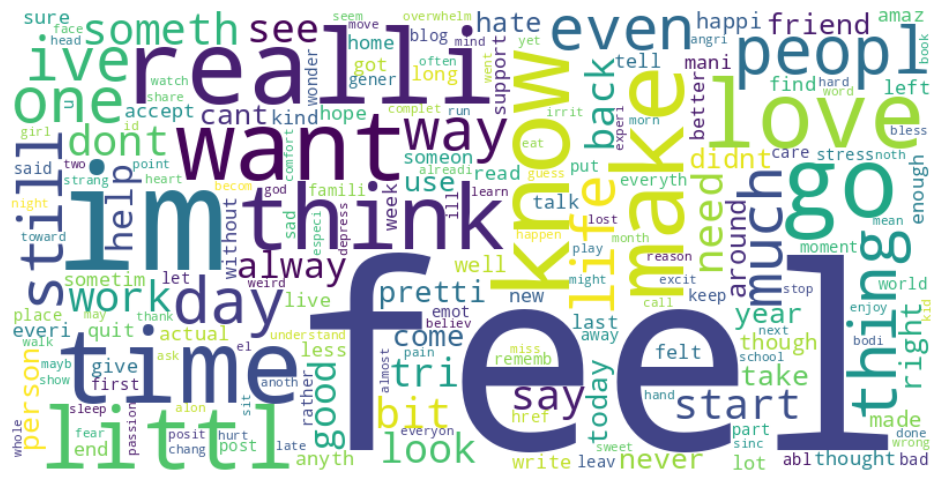

In [6]:
# Concatène tous les textes en une seule chaîne
texte_total = " ".join(data['clean_text'].dropna().astype(str))

# Génère le WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False  # pour éviter les doublons de mots collés
).generate(texte_total)

# Affiche le WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
# Vectorisation 
vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1,2), 
    stop_words='english'
)

X = vectorizer.fit_transform(data['text'])
y = data['label']  

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


# Model

In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=emotion_map.values()))

Accuracy: 0.8876586454259735
              precision    recall  f1-score   support

     sadness       0.91      0.96      0.93     24504
         joy       0.85      0.97      0.91     28247
        love       0.91      0.63      0.74      6853
       anger       0.94      0.86      0.90     11339
        fear       0.89      0.82      0.85      9376
    surprise       0.88      0.49      0.63      3043

    accuracy                           0.89     83362
   macro avg       0.90      0.79      0.83     83362
weighted avg       0.89      0.89      0.88     83362



In [9]:
def evaluation(data, model):
    # === Génération des courbes d'apprentissage ===
    vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1,2), 
    stop_words='english')
    
    X = vectorizer.fit_transform(data['text'])
    y = data['label']

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5),
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        n_jobs=-1
    )

    # Moyenne et écart-type des scores
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_std = val_scores.std(axis=1)
    
    # === Affichage ===
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title("Courbes d'apprentissage")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

{'force_alpha': False, 'fit_prior': False, 'class_prior': None, 'alpha': 3.0}
Accuracy: 0.8931167678318659
              precision    recall  f1-score   support

     sadness       0.97      0.90      0.93     24504
         joy       0.97      0.86      0.91     28247
        love       0.68      0.96      0.80      6853
       anger       0.89      0.92      0.91     11339
        fear       0.86      0.87      0.86      9376
    surprise       0.61      0.95      0.75      3043

    accuracy                           0.89     83362
   macro avg       0.83      0.91      0.86     83362
weighted avg       0.91      0.89      0.90     83362



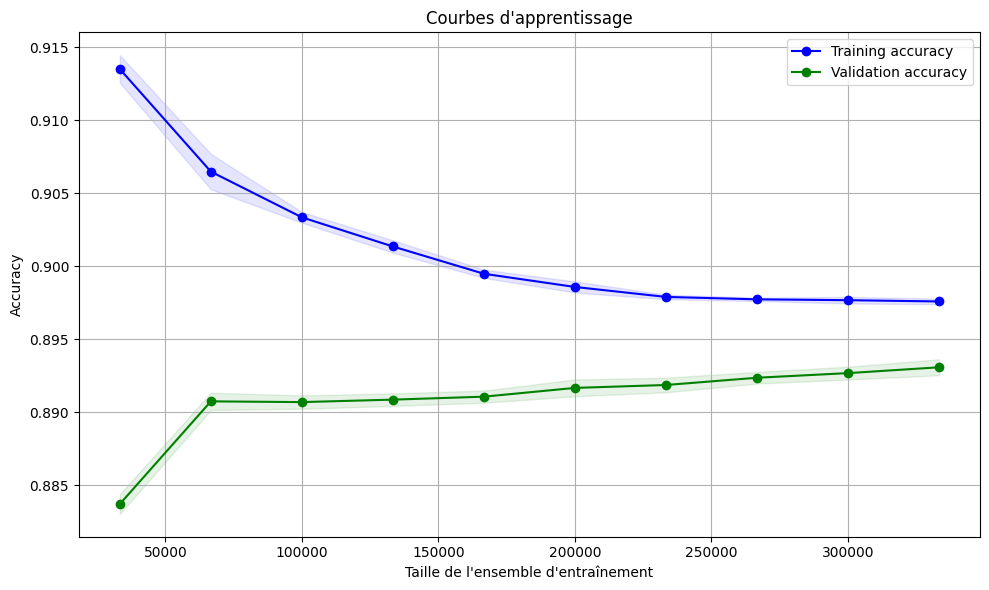

In [10]:
model = MultinomialNB()

params = {'alpha' : [0.1, 0.5, 1.0,3.0, 10.0, 30.0, 50.0, 100.0],
          'force_alpha' : [True, False],
          'fit_prior' : [True, False], 
          'class_prior': [None]
          }

grid = RandomizedSearchCV(model, params, cv=5, n_iter=10,random_state=42)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=emotion_map.values()))

evaluation(data,grid.best_estimator_)



## Deep Learning

In [36]:
# Paramètres
vocab_size = 1000
max_len = 20

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X = padded_sequences
y = data['label']

In [37]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),  # plus rapide que LSTM
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 392s 38ms/step - accuracy: 0.3313 - loss: 1.5808 - val_accuracy: 0.3388 - val_loss: 1.5703
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 389s 37ms/step - accuracy: 0.3384 - loss: 1.5754 - val_accuracy: 0.3388 - val_loss: 1.5709
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 395s 38ms/step - accuracy: 0.3381 - loss: 1.5754 - val_accuracy: 0.3388 - val_loss: 1.5705
2606/2606 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.3383 - loss: 1.5701
Test Accuracy: 0.34


In [ ]:
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)
plot_training_curves(history)

In [ ]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    label_idx = np.argmax(pred)
    return label_encoder.inverse_transform([label_idx])[0]

print(predict_sentiment("I really enjoyed this experience!"))

# Transformers

In [20]:
from transformers import pipeline
import torch

classifier = pipeline("sentiment-analysis")
print(data['text'][2])
print(classifier(data['text'][2]))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals
[{'label': 'POSITIVE', 'score': 0.9998210072517395}]


In [29]:
from transformers import pipeline

# Ce modèle est entraîné spécifiquement pour du NER sur des tweets
ner_pipeline = pipeline(
    "ner",
    model="Babelscape/wikineural-multilingual-ner",
    aggregation_strategy="simple"
)

texte = data['text'][0]
entities = ner_pipeline(texte)

for entity in entities:
    print(f"Entité : {entity['word']}, Type : {entity['entity_group']}")

Device set to use cpu
